# Locating recombinant haplotypes - demo

This notebook has a demo of the function "locate_recombinants" from the hapclust_utils notebook. The function identifies haplotypes with evidence for recombination based on the 4-gamete test.

In [25]:
%run setup.ipynb
import hapclust
%matplotlib inline

In [2]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .addfield('label', lambda row: row['AGAP004707-RA'] if row['AGAP004707-RA'] else '%s:%s>%s' % (row.POS, row.REF, row.ALT))
)
tbl_variant_labels

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2358254,G,A,D33N,D33N
2358316,T,G,,2358316:T>G
2358328,T,C,,2358328:T>C
2358353,C,T,,2358353:C>T
2358405,T,A,,2358405:T>A


In [3]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[pos_995F]

'L995F'

In [4]:
pos2label_coding = tbl_variant_labels.lookupone('POS', 'AGAP004707-RA')
pos2label_coding[pos_995F]

'L995F'

In [5]:
variant_labels = np.array([pos2label.get(p, '') for p in pos], dtype=object)
variant_labels_vgsc = variant_labels[loc]
variant_labels_vgsc

array(['D33N', '2358316:T>G', '2358328:T>C', ..., '2431518:C>A',
       '2431527:G>C', '2431542:T>C'], dtype=object)

In [6]:
variant_labels_coding = np.array([pos2label_coding.get(p, '') for p in pos], dtype=object)
variant_labels_coding_vgsc = variant_labels_coding[loc]
variant_labels_coding_vgsc

array(['D33N', '', '', ..., '', '', ''], dtype=object)

## L995S

In [9]:
cut_height = 2
fig, ax_dend, ax_freq, cluster_spans_995S, leaf_obs_995S = hapclust.fig_haplotypes_clustered(
    h_vgsc_995S, cut_height=cut_height, dpi=150, 
    highlight_clusters=5, label_clusters=5)


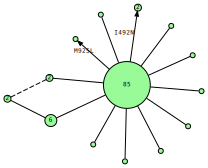

In [10]:
cluster_idx = 2
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

221 1473 [ 2  2  6 96] (0, 0) {60, 13}
221 1473 [ 2  2  6 96] (0, 1) {88, 34}
found 2 solutions; min recombinant haplotypes: 2


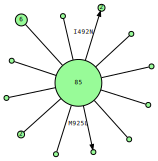

In [12]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

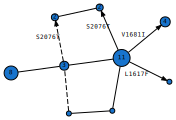

In [13]:
cluster_idx = 9
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

364 431 [18  1 13  1] (0, 1) {9}
364 431 [18  1 13  1] (1, 1) {5}
364 1714 [17  2 12  2] (0, 1) {19, 14}
364 1714 [17  2 12  2] (1, 1) {26, 29}
found 4 solutions; min recombinant haplotypes: 3


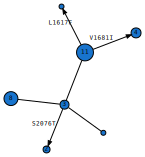

In [14]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

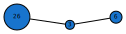

In [15]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


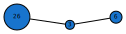

In [16]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', 
    variant_labels=variant_labels_coding_vgsc, fontsize=6, show_node_labels='count')

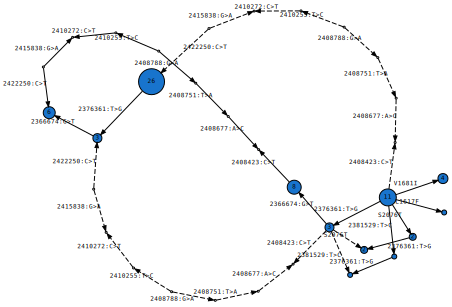

In [17]:
cluster_idx = 9, 12
cluster_hap_indices = list()
for i in cluster_idx:
    _, _, hix = cluster_spans_995S[i]
    cluster_hap_indices.extend(hix)
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

209 1227 [25 29  8  6] (1, 1) {34, 37, 39, 41, 56, 60}
209 1248 [29 25  6  8] (1, 0) {34, 37, 39, 41, 56, 60}
209 1251 [29 25  6  8] (1, 0) {34, 37, 39, 41, 56, 60}
209 1253 [29 25  6  8] (1, 0) {34, 37, 39, 41, 56, 60}
209 1286 [25 29  8  6] (1, 1) {34, 37, 39, 41, 56, 60}
209 1287 [25 29  8  6] (1, 1) {34, 37, 39, 41, 56, 60}
209 1421 [29 25  6  8] (1, 0) {34, 37, 39, 41, 56, 60}
209 1525 [25 29  8  6] (1, 1) {34, 37, 39, 41, 56, 60}
364 431 [44  1 22  1] (0, 1) {9}
364 431 [44  1 22  1] (1, 1) {5}
364 1227 [19 26 14  9] (1, 1) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1248 [26 19  9 14] (1, 0) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1251 [26 19  9 14] (1, 0) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1253 [26 19  9 14] (1, 0) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1286 [19 26 14  9] (1, 1) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1287 [19 26 14  9] (1, 1) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1421 [26 19  9 14] (1, 0) {34, 37, 39, 41, 51, 53, 55, 56, 60}
364 1525 [19 26 14  9] (1

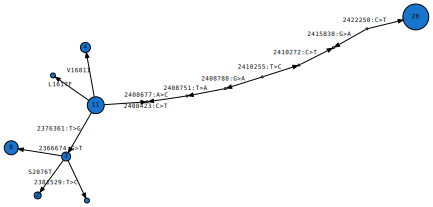

In [18]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

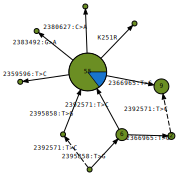

In [19]:
cluster_idx = 14
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

224 895 [ 7 60  2  9] (1, 0) {24, 20}
895 1031 [ 1  8  1 68] (0, 0) {16}
895 1031 [ 1  8  1 68] (1, 0) {36}
found 2 solutions; min recombinant haplotypes: 3


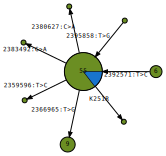

In [20]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

## L995F

In [23]:
cut_height = 4
fig, ax_dend, ax_freq, cluster_spans_995F, leaf_obs_995F = hapclust.fig_haplotypes_clustered(
    h_vgsc_995F, cut_height=cut_height, dpi=150, 
    highlight_clusters=5, label_clusters=5)


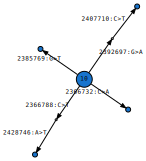

In [24]:
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


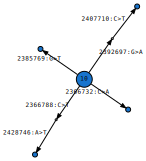

In [27]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

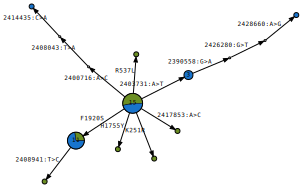

In [28]:
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


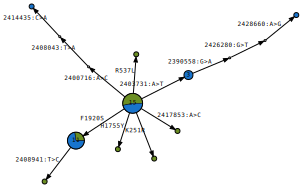

In [29]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

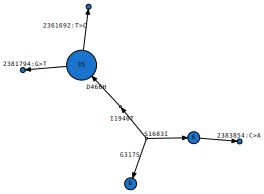

In [30]:
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


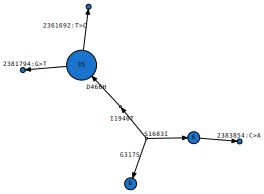

In [32]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

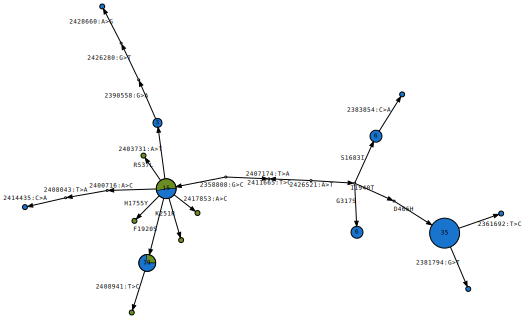

In [33]:
# look at clusters 7 and 8 together
cluster_idx = 7, 8
cluster_hap_indices = list()
for i in cluster_idx:
    _, _, hix = cluster_spans_995F[i]
    cluster_hap_indices.extend(hix)
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


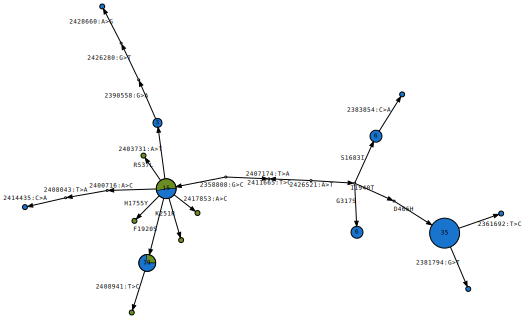

In [34]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

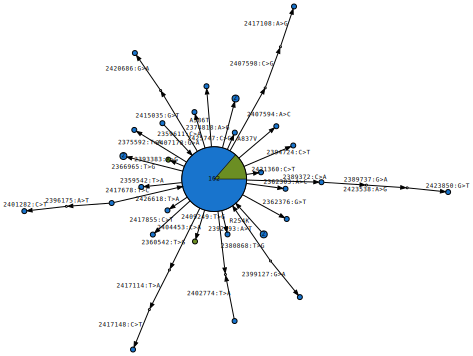

In [35]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

found 1 solutions; min recombinant haplotypes: 0


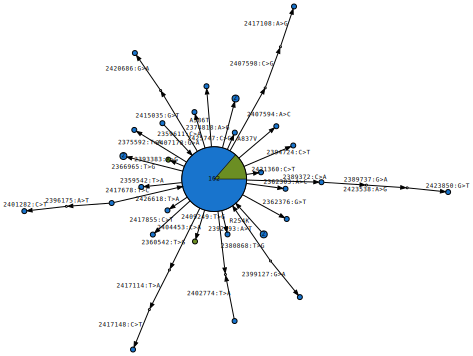

In [36]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]))
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

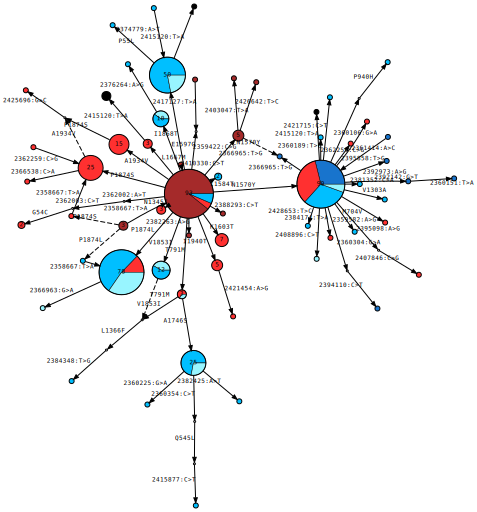

In [37]:
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
hapclust.graph_haplotype_network(
    cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', 
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')

6 1698 [  4   1 442  28] (0, 1) {172}
6 1699 [  4   1 391  79] (0, 1) {39}
147 1674 [  1   1 364 109] (0, 0) {243}
147 1674 [  1   1 364 109] (0, 1) {291}
147 1698 [  1   1 445  28] (0, 0) {291}
147 1698 [  1   1 445  28] (0, 1) {243}
224 1674 [358 109   7   1] (1, 1) {282}
1379 1674 [361 109   4   1] (1, 1) {474}
1379 1681 [467   3   2   3] (1, 0) {473, 474}
1379 1697 [418  52   4   1] (1, 1) {473}
1433 1695 [431  12  31   1] (1, 1) {87}
1698 1704 [431  15  28   1] (1, 1) {242}
found 4 solutions; min recombinant haplotypes: 8 [8, 8, 9, 9]


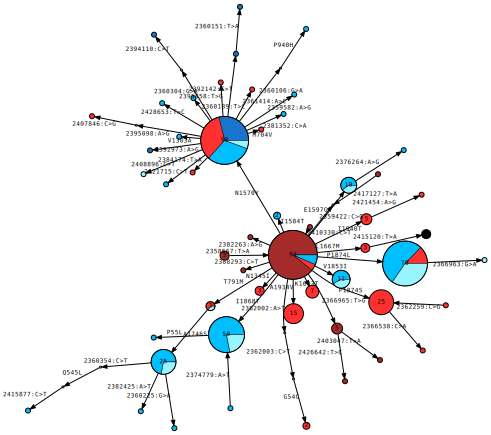

In [38]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=True)
print('found', len(idx_rec), 'solutions; min recombinant haplotypes:', len(idx_rec[0]), [len(s) for s in idx_rec])
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
hapclust.graph_haplotype_network(
    cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
    variant_labels=variant_labels_vgsc, fontsize=6, show_node_labels='count')